In [377]:
import os
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Preprocessing

# Trainset

In [328]:
basepath = 'datasci_dataset_2022'
province = ['BKK', 'Chiangmai', 'Khonkaen', 'Rayong', 'Saraburi', 'Surat']
mode = 'train'
idx = 5

folderpath = os.path.join(basepath, province[idx])

train = pd.read_csv(os.path.join(os.path.join(folderpath, f'{mode}\\{province[idx].lower()}_{mode}.csv')))
temp_surface = pd.read_csv(os.path.join(folderpath, f'{mode}\\{province[idx].lower()}_temp_surface.csv'))
weather_wind = pd.read_csv(os.path.join(folderpath, f'{mode}\\{province[idx].lower()}_weather_wind.csv'))

train['Unnamed: 0'] = pd.to_datetime(train['Unnamed: 0'])
temp_surface['date_time'] = pd.to_datetime(temp_surface['date_time'])
weather_wind['date_time'] = pd.to_datetime(weather_wind['date_time'])

## Join PM2.5, wind, and temperature

In [329]:
exog_feat = temp_surface.join(weather_wind.set_index('date_time'), on='date_time')
train_data = train.join(exog_feat.set_index('date_time'), on='Unnamed: 0')
train_data.rename({'Unnamed: 0': 'date_time'}, axis=1, inplace=True)
train_data['date_time'] = pd.to_datetime(train_data['date_time'])
train_data.set_index('date_time', inplace=True)
train_data = train_data.reindex(pd.date_range("2017-07-01 00:00:00", "2020-06-30 23:00:00",freq='h'), fill_value=np.nan) ## sort by datetime
train_data = train_data.interpolate(limit_direction='both')

# train_data = train_data.reindex(pd.date_range("2017-07-01 00:00:00", "2020-06-30 23:00:00",freq='6h'), fill_value=np.nan)

## Preprocessing Hotspot

### Day hotspot

In [330]:
hotspotDay_data = pd.read_csv('datasci_dataset_2022\\hotspot_day_train.csv')

hotspotDay_data['date'] = pd.to_datetime(hotspotDay_data['date'])
hotspotDay_data = hotspotDay_data.set_index('date')
hotspotDay_data = hotspotDay_data.resample('1h').pad().between_time('06:00', '17:00')

### Night hotspot

In [331]:
hotspotNight_data = pd.read_csv('datasci_dataset_2022\\hotspot_night_train.csv')

hotspotNight_data['date'] = pd.to_datetime(hotspotNight_data['date'])
hotspotNight_data = hotspotNight_data.set_index('date')
hotspotNight = hotspotNight_data.resample('1h').pad().between_time('18:00', '05:00')

### Join day and night hotspot

In [332]:
hotspot = pd.concat([hotspotDay_data, hotspotNight]).sort_index()

## Join all exog feat with PM2.5

In [333]:
train_data = train_data.join(hotspot)

In [334]:
train_data = train_data.reindex(pd.date_range("2017-07-01 00:00:00", "2020-06-30 23:00:00",freq='6h'), fill_value=np.nan)

In [335]:
train_data.to_csv(os.path.join(folderpath, f'{mode}\\{mode}ing.csv'))

In [336]:
train_data

,PM2.5,temp,wind speed,wind dir,P_Malaysia,Lao_PDR,Thailand,Vietnam,Myanmar
2017-07-01 00:00:00,22.0,25.800000,3.000000,90.000000,0,0,0,0,0
2017-07-01 06:00:00,22.0,25.800000,3.000000,90.000000,1,0,0,21,0
2017-07-01 12:00:00,22.0,25.800000,3.000000,90.000000,1,0,0,21,0
2017-07-01 18:00:00,22.0,25.800000,3.000000,90.000000,0,0,0,0,0
2017-07-02 00:00:00,22.0,25.800000,3.000000,90.000000,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
2020-06-29 18:00:00,12.0,27.566667,19.666667,235.000000,0,0,0,0,0
2020-06-30 00:00:00,21.0,25.400000,26.666667,250.000000,0,0,0,0,0
2020-06-30 06:00:00,24.0,25.133333,26.000000,248.333333,0,0,2,4,0
2020-06-30 12:00:00,19.0,30.633333,16.000000,231.666667,0,0,2,4,0


# Testset

In [337]:
mode = 'test'
test = pd.read_csv(os.path.join(os.path.join(folderpath, f'{mode}\\{province[idx].lower()}_{mode}.csv')))
temp_surface = pd.read_csv(os.path.join(folderpath, f'{mode}\\{province[idx].lower()}_temp_surface.csv'))
weather_wind = pd.read_csv(os.path.join(folderpath, f'{mode}\\{province[idx].lower()}_weather_wind.csv'))

test['Unnamed: 0'] = pd.to_datetime(test['Unnamed: 0'])
temp_surface['date_time'] = pd.to_datetime(temp_surface['date_time'])
weather_wind['date_time'] = pd.to_datetime(weather_wind['date_time'])
weather_wind.rename({'wind direction': 'wind dir'}, axis=1, inplace=True)
print("Test Nan:", test.isna().sum())

Test Nan: Unnamed: 0      0
PM2.5         696
dtype: int64


## Join PM2.5, wind, temperature

We can't interpolate as same as train set, because the future data may be used in the interpolation operation.

In [338]:
exog_feat = temp_surface.join(weather_wind.set_index('date_time'), on='date_time')
test_data = test.join(exog_feat.set_index('date_time'), on='Unnamed: 0')
test_data.rename({'Unnamed: 0': 'date_time'}, axis=1, inplace=True)
test_data['date_time'] = pd.to_datetime(test_data['date_time'])
test_data.set_index('date_time', inplace=True)
test_data = test_data.reindex(pd.date_range("2020-07-01 00:00:00", "2021-07-01 23:00:00",freq='h'), fill_value=np.nan) ## sort by datetime
#test_data = test_data.interpolate(limit_direction='forward') # must interpolate in forward direction in order to prevent data leak.

In [339]:
cur_data = train_data.copy().iloc[:, :4]
for i in range(len(test_data)):
  cur_data = pd.concat([cur_data, test_data.iloc[i:i+1]])
  cur_data = cur_data.interpolate(limit_direction='forward')

## Preprocessing Hotspot

### Day Hotspot

In [340]:
hotspotDay_data = pd.read_csv('datasci_dataset_2022\\hotspot_day_test.csv')

hotspotDay_data['date'] = pd.to_datetime(hotspotDay_data['date'])
hotspotDay_data = hotspotDay_data.set_index('date')
hotspotDay_data = hotspotDay_data.resample('1h').pad().between_time('06:00', '17:00')

### Night Hotspot

In [341]:
hotspotNight_data = pd.read_csv('datasci_dataset_2022\\hotspot_night_test.csv')

hotspotNight_data['date'] = pd.to_datetime(hotspotNight_data['date'])
hotspotNight_data = hotspotNight_data.set_index('date')
hotspotNight_data = hotspotNight_data.resample('1h').pad().between_time('18:00', '05:00')

In [342]:
hotspotNight_data

,P_Malaysia,Lao_PDR,Thailand,Vietnam,Myanmar
date,,,,,
2020-07-01 00:00:00,0,0,0,0,0
2020-07-01 01:00:00,0,0,0,0,0
2020-07-01 02:00:00,0,0,0,0,0
2020-07-01 03:00:00,0,0,0,0,0
2020-07-01 04:00:00,0,0,0,0,0
...,...,...,...,...,...
2021-07-01 20:00:00,0,0,0,0,0
2021-07-01 21:00:00,0,0,0,0,0
2021-07-01 22:00:00,0,0,0,0,0


### Join day and night Hotspot

In [343]:
hotspot = pd.concat([hotspotDay_data, hotspotNight_data]).sort_index()

## Join all exog feat with PM2.5

In [344]:
test_data = cur_data.reindex(pd.date_range("2020-07-01 00:00:00", "2021-07-01 23:00:00",freq='h'), fill_value=np.nan)

In [345]:
test_data = test_data.join(hotspot)

In [346]:
test_data = test_data.reindex(pd.date_range("2020-07-01 00:00:00", "2021-07-01 23:00:00",freq='6h'), fill_value=np.nan)

In [347]:
test_data.to_csv(os.path.join(folderpath, f'{mode}\\{mode}ing.csv'))

In [348]:
test_data

,PM2.5,temp,wind speed,wind dir,P_Malaysia,Lao_PDR,Thailand,Vietnam,Myanmar
2020-07-01 00:00:00,19.0,28.066667,19.0,251.666667,0,0,0,0,0
2020-07-01 06:00:00,23.0,24.700000,29.0,255.000000,0,0,0,8,0
2020-07-01 12:00:00,18.0,29.300000,36.0,250.000000,0,0,0,8,0
2020-07-01 18:00:00,16.0,31.800000,29.0,260.000000,0,0,0,0,0
2020-07-02 00:00:00,18.0,25.900000,25.0,270.000000,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
2021-06-30 18:00:00,12.0,28.700000,14.0,270.000000,0,0,0,2,0
2021-07-01 00:00:00,11.0,24.900000,11.0,255.000000,0,0,0,0,0
2021-07-01 06:00:00,11.0,23.800000,11.0,255.000000,0,0,2,10,0
2021-07-01 12:00:00,13.0,32.200000,9.0,235.000000,0,0,2,10,0


# Visualization

In [399]:
basepath = 'datasci_dataset_2022'
province = ['BKK', 'Chiangmai', 'Khonkaen', 'Rayong', 'Saraburi', 'Surat']
mode = 'train'
idx = 4
print(f"Load data from {province[idx]}")

folderpath = os.path.join(basepath, province[idx])

mode = 'train'
train_data = pd.read_csv(os.path.join(folderpath, f'{mode}\\{mode}ing.csv')).rename({'Unnamed: 0': "date_time"}, axis=1)
train_data['date_time'] = pd.to_datetime(train_data['date_time'])
train_data = train_data.set_index('date_time')

mode = 'test'
test_data = pd.read_csv(os.path.join(folderpath, f'{mode}\\{mode}ing.csv')).rename({'Unnamed: 0': "date_time"}, axis=1)
test_data['date_time'] = pd.to_datetime(test_data['date_time'])
test_data = test_data.set_index('date_time')

data = pd.concat([train_data, test_data]).sort_index()

Load data from Saraburi


## Plot the relation between hotspot and PM2.5

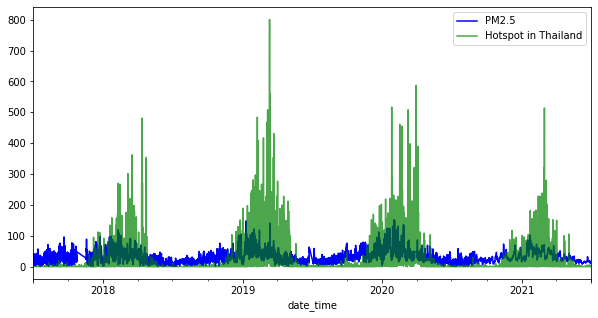

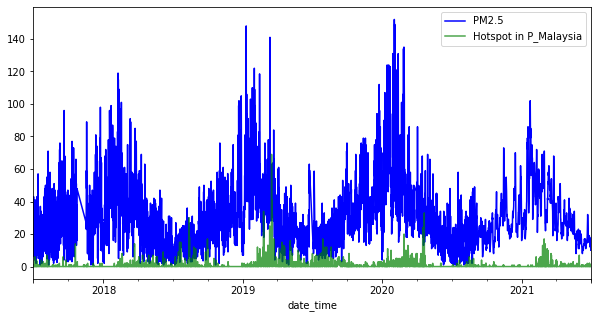

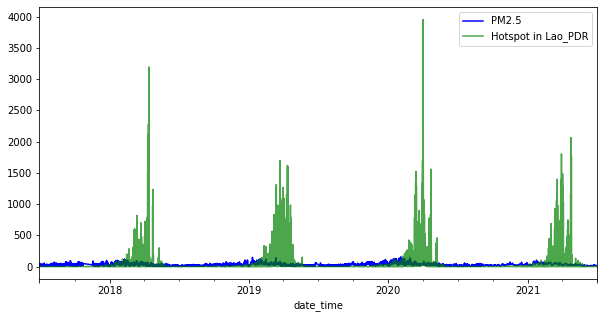

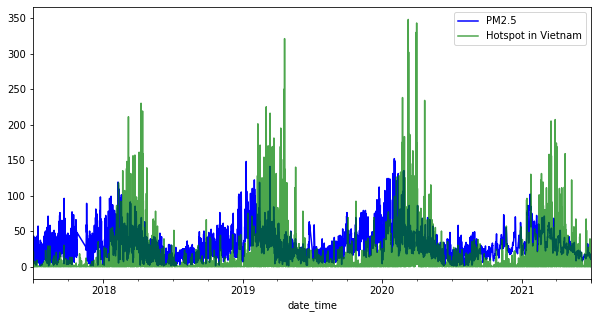

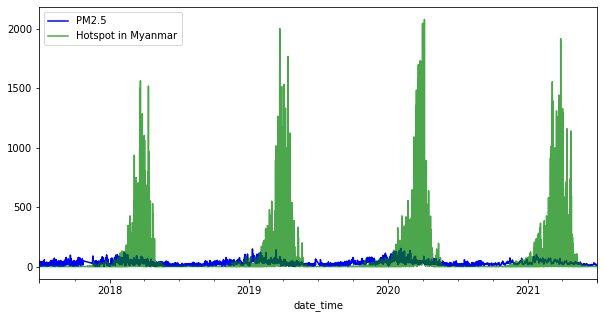

In [400]:
hotspot = ['Thailand', 'P_Malaysia', 'Lao_PDR', 'Vietnam', 'Myanmar']

for loc in hotspot:
  plt.figure(figsize=(10, 5))
  data['PM2.5'].plot(color='b',label='PM2.5')
  data[loc].plot(alpha=0.7, color='g',label=f'Hotspot in {loc}')
  plt.legend()
  plt.show()

## Plot PM2.5 and Temperature

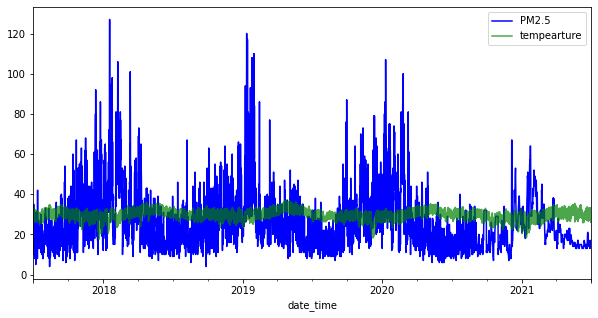

In [368]:
plt.figure(figsize=(10, 5))
data['PM2.5'].plot(color='b',label='PM2.5')
data['temp'].plot(alpha=0.7, color='g',label=f'tempearture')
plt.legend()
plt.show()

## Plot PM2.5 and Wind Speed

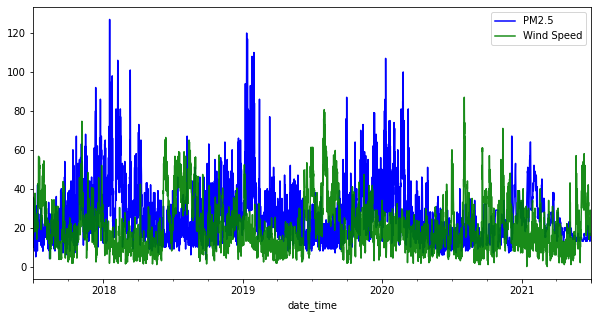

In [371]:
plt.figure(figsize=(10, 5))
data['PM2.5'].plot(color='b',label='PM2.5')
data['wind speed'].plot(alpha=0.9, color='g',label=f'Wind Speed')
plt.legend()
plt.show()

## Plot PM2.5 and Wind Direction

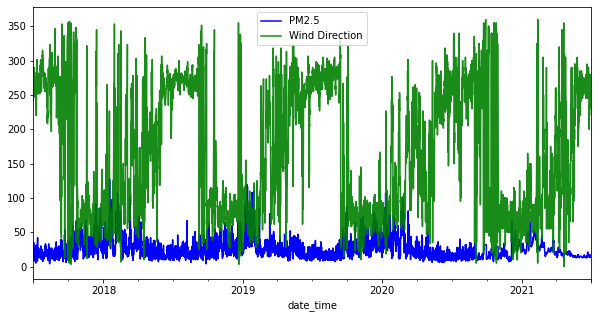

In [372]:
plt.figure(figsize=(10, 5))
data['PM2.5'].plot(color='b',label='PM2.5')
data['wind dir'].plot(alpha=0.9, color='g',label=f'Wind Direction')
plt.legend()
plt.show()

## Plot Correlation

In [378]:
corr = data.corr()

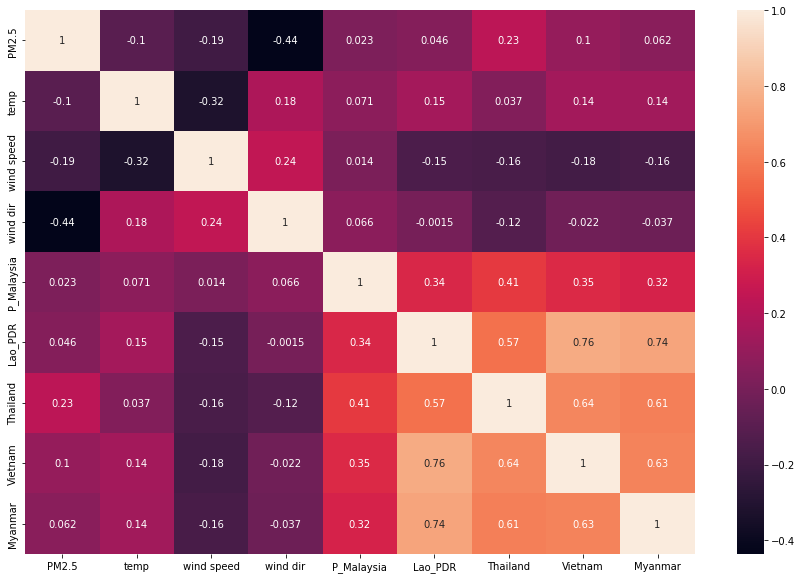

In [385]:
plt.figure(figsize=(15, 10))
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        annot=True)
plt.show()